# Cartopy and the matplotlib interface

## Purpose

The purpose of this section is to give you an overview of cartopy's matplotlib interface and its documentation. This will help you to:
 
 * apply cartopy's matplotlib interface to your own situation/application
 * navigate cartopy's documentation effectively

There is more to cartopy than the matplotlib interface.

## Cartopy's documentation

https://scitools.org.uk/cartopy/docs/latest/

Cartopy makes use of the powerful PROJ.4, numpy and shapely libraries and includes a programatic interface built on top of Matplotlib for the creation of publication quality maps.

Key features of cartopy are its object oriented projection definitions, and its ability to transform points, lines, vectors, polygons and images between those projections.


## Cartopy Projections and other reference systems

In Cartopy, each projection is a class.
Most classes of projection can be configured in projection-specific ways, although Cartopy takes an opinionated stance on sensible defaults.

Let's create a Plate Carree projection instance.

To do so, we need cartopy's crs module. This is typically imported as ``ccrs`` (Cartopy Coordinate Reference Systems).

In [1]:
import cartopy.crs as ccrs

Cartopy's projection list tells us that the Plate Carree projection is available in the ``ccrs.PlateCarree`` class:

https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

**Note:** we need to *instantiate* the class in order to do anything projection-y with it!


In [4]:
ccrs.PlateCarree()

## Drawing a map

Cartopy optionally depends upon matplotlib, and each projection knows how to create a matplotlib Axes (or AxesSubplot) that can represent itself.

The Axes that the projection creates is a [cartopy.mpl.geoaxes.GeoAxes](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes). This Axes subclass overrides some of matplotlib's existing methods, and adds a number of extremely useful ones for drawing maps.

We'll go back and look at those methods shortly, but first, let's actually see the cartopy+matplotlib dance in action:

<IPython.core.display.Javascript object>


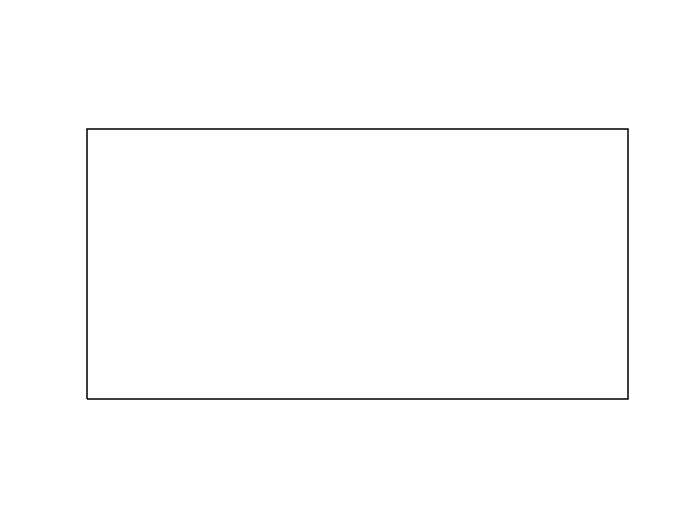

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.axes(projection=ccrs.PlateCarree())

That was a little underwhelming, but we can see that the Axes created is indeed one of those GeoAxes[Subplot] instances.

One of the most useful methods that this class adds on top of the standard matplotlib Axes class is the ``coastlines`` method. With no arguments, it will add the Natural Earth ``1:110,000,000`` scale coastline data to the map.

<IPython.core.display.Javascript object>


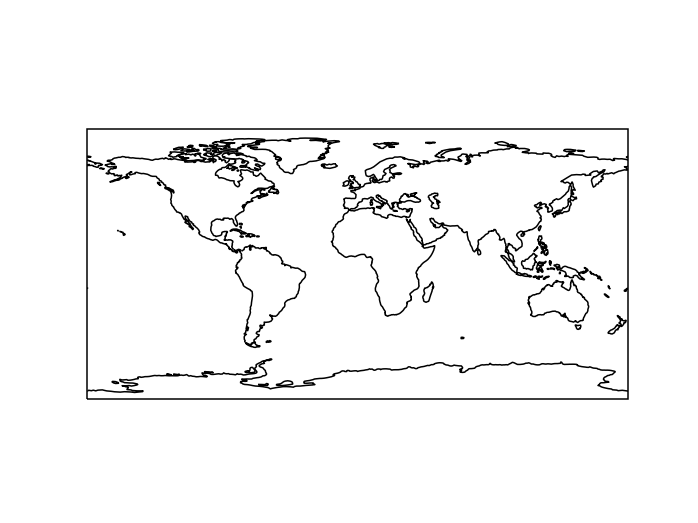

In [7]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

We could just as equally created a matplotlib subplot with one of the many approaches that exist. For example, the ```plt.subplots``` function could be used:

<IPython.core.display.Javascript object>


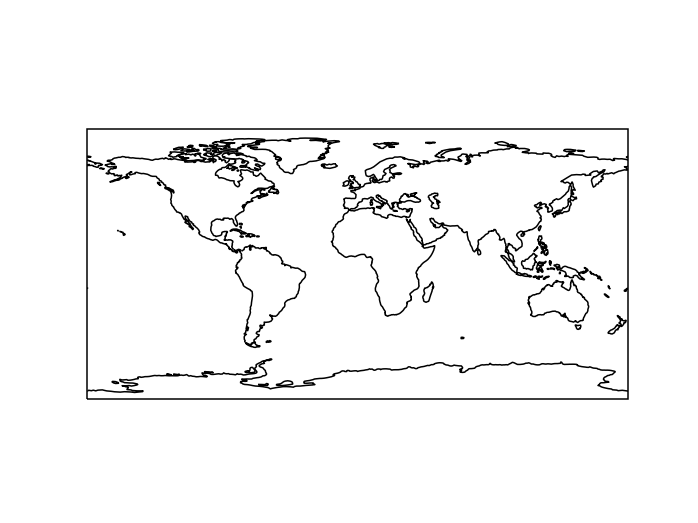

In [8]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

## Useful methods of a GeoAxes

The [cartopy.mpl.geoaxes.GeoAxes](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes) class adds a number of useful methods.

Let's take a look at:

 * [set_global](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.set_global) - zoom the map out as much as possible
 * [set_extent](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.set_extent) - zoom the map to the given bounding box
 

 * [gridlines](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.graticule) - add a graticule (and optionally labels) to the axes
 * [coastlines](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.coastlines) - add Natural Earth coastlines to the axes
 * [stock_img](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.stock_img) - add a low-resolution Natural Earth background image to the axes
 
 
 * [imshow](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html#matplotlib.axes.Axes.imshow) - add an image (numpy array) to the axes
 * [add_geometries](https://scitools.org.uk/cartopy/docs/latest/matplotlib/geoaxes.html#cartopy.mpl.geoaxes.GeoAxes.add_geometries) - add a collection of geometries (Shapely) to the axes

<IPython.core.display.Javascript object>


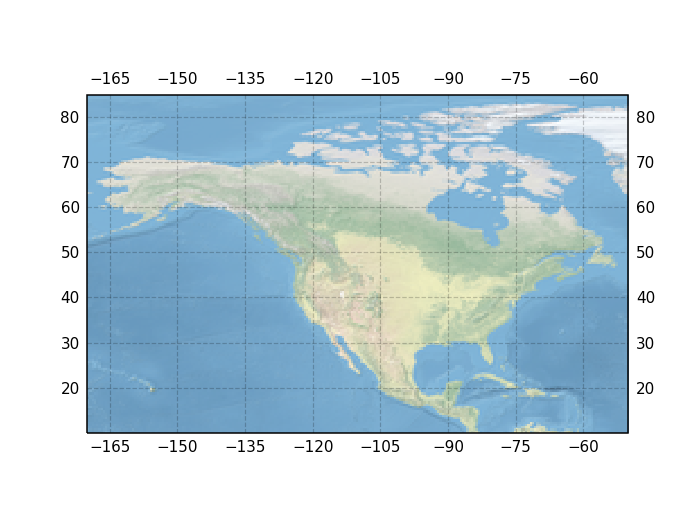

In [53]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-170, -50, 10, 80])
ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
ax.stock_img()

It'd be nice to have state boundaries and a higher resolution image here.

There are built-in tools for doing this in cartopy, but let's start with the manual approach...

A higher resolution image [from Natural Earth](https://www.naturalearthdata.com/downloads/50m-raster-data/50m-natural-earth-2/) is available in ``resources/natural-earth-2/global.png``.
Matplotlib can read PNGs out of the box, so let's use that. Alternatives include pillow, scikit-image, etc.

In [28]:
img = plt.imread('resources/natural-earth-2/global.png')
print(img.shape)

(1000, 2000, 3)


A shapefile containing the US state boundaries [from Natural Earth](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/) is available in ``resources/states/states.shp``.

There are a number of ways of loading a shapefile, Fiona is one particularly fast approach, but geopandas and pyshp are equally valid.

In [38]:
import fiona
import shapely.geometry as sgeom

shpfile = 'resources/states/states.shp'
records = fiona.open(shpfile)
geometries = [sgeom.shape(shp['geometry'])
              for shp in records]

Now that we've made use of these tools to give us an image (numpy array) and a list of Shapely geometries, let's re-create that map and include our new data.

<IPython.core.display.Javascript object>


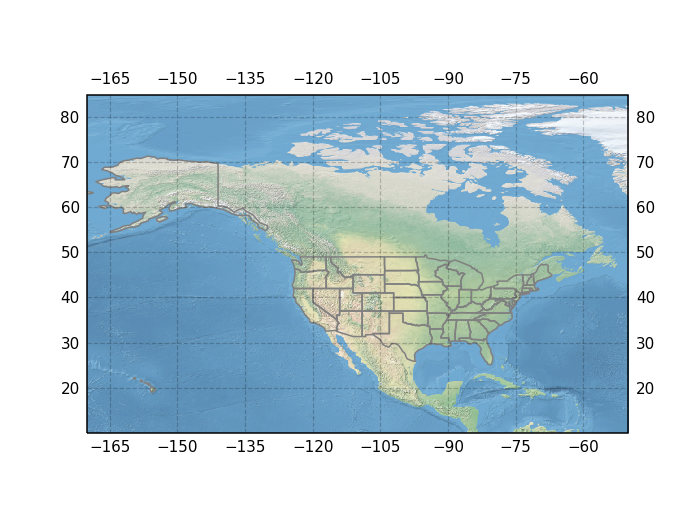

In [58]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

def north_america(ax):
    ax.set_extent([-170, -50, 10, 80])
    ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')

    ax.imshow(img, origin='upper',
              extent=[-180, 180, -90, 90],
              transform=ccrs.PlateCarree())

    ax.add_geometries(geometries, ccrs.PlateCarree(),
                      edgecolor='gray', facecolor='none')

north_america(ax)

There are some important things to note here.

1. We are doing more work than we strictly need to here. Cartopy already has the ability to draw States via its [Feature interface](https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html).


2. We are leveraging the power of matplotlib with this interface, we don't need to re-learn terms for how to style things. We can use the exact same syntax as we do with matplotlib (e.g. ``edgecolor``, ``facecolor``, ``linestyle``).


3. When we added data to the Axes, we specified both the data to plot **and** the coordinate system of that data using the ``transform`` keyword argument.


## Why it is important to specify the *coordinate system* of *the data* as well as the *projection* of *the map*

You've now seen that the map's projection is defined with the ``projection`` keyword argument when constructing an Axes. You've also seen that when data is added to the Axes it requires coordinate system via the ``transform`` keyword argument.

> The single most important feature of cartopy is that it is designed to project your data for you.<br>
> **On the whole, cartopy will do the right thing when it comes to poles, anti-meridians, interpolation and map boundaries.**


The coordinate reference system can be used to control how the coordinates of your data are interpreted.
On the sphere there are infinitely many ways to draw a line between two points. The two most common ways of drawing a line between two points on the sphere are:

 * as straight lines in projected space
 * as the line of shortest distance on the sphere (Geodetic).

Let's visualize these by drawing a line between New York and San Fransisco.

<IPython.core.display.Javascript object>


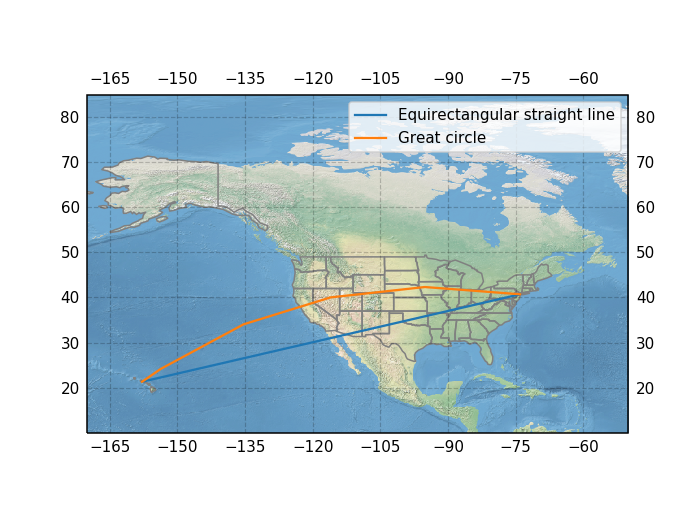

In [64]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
north_america(ax)

new_york = -74.0060, 40.7128
san_fransisco = -122.4194, 37.7749
honolulu = -157.8583, 21.3069

lons = [new_york[0], honolulu[0]]
lats = [new_york[1], honolulu[1]]

plt.plot(lons, lats, transform=ccrs.PlateCarree(),
         label='Equirectangular straight line')
plt.plot(lons, lats, transform=ccrs.Geodetic(),
         label='Great circle')
plt.legend()

Next Steps: 
 * Changing the projection
 * Wrapping the dateline
 * Recognising where cartopy is poor
 * An exercise